In [2]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

In [3]:
import os

os.chdir("..")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
import torch
import matplotlib.pyplot as plt

from orthogonal_dfa.l_star.examples.bernoulli_parity import BernoulliParityOracle
from orthogonal_dfa.l_star.structures import DecisionTreeLeafNode
from orthogonal_dfa.l_star.sampler import UniformSampler
from orthogonal_dfa.l_star.decision_tree_to_dfa import *
from orthogonal_dfa.utils.pdfa import batched_iterated_matrix_multiply

In [136]:
oracle = BernoulliParityOracle(0.6, 0, modulo=7, allowed_moduluses=(2, 5))

In [137]:
# oracle.membership_query([0, 0, 1, 0, 1, 1, 1])

In [138]:
us = UniformSampler(40)

In [139]:
# us.sample(np.random.default_rng(2))

In [140]:
# import scipy

In [141]:
# help(scipy.stats.chisquare)

In [142]:
# chi_squared_p(np.arange(1000) % 62 == 0, np.arange(1000) % 64 == 0)

In [143]:
s = 0
a = 1
v = []

In [144]:
# pt = {}
# dt = DecisionTreeLeafNode(0)
# # dt = dt.add_state(0, lambda x, o: o.membership_query(x + []))
# # dt = dt.add_state(0, lambda x, o: o.membership_query(x + [1]))
# # dt = dt.add_state(0, lambda x, o: o.membership_query(x + [1, 1]))

In [145]:
# p_req = 0.005

In [146]:
# min_samples_per_state = 3000
# while True:
#     result = compute_strings_by_state(
#         alphabet_size=2,
#         dt=dt,
#         oracle=oracle,
#         sampler=us,
#         min_samples_per_state=min_samples_per_state,
#         seed=0,
#     )
#     # if len(result) > 1:
#     #     break
#     for state in result:
#         res, _ = find_correlated_strings(
#             result[state][:min_samples_per_state],
#             oracle,
#             us,
#             p_req,
#             100,
#             1000,
#             num_strings=30,
#         )
#         print(state, res is not None)
#         if res is not None:
#             break
#     else:
#         break
#     print(state, [sum(v) for v in res], flush=True)
#     dt = dt.split_state(state, dt.num_states, TriPredicate(res, 0.6))

In [147]:
# plt.hist(np.array(result[0]).sum(1) % 4)
# plt.hist(np.array(result[1]).sum(1) % 4)
# plt.hist(np.array(result[2]).sum(1) % 4)
# plt.hist(np.array(result[3]).sum(1) % 4)

In [148]:
# decision_tree_to_dfa(
#     alphabet_size=2,
#     dt=dt,
#     oracle=oracle,
#     sampler=us,
#     min_samples_per_state=100,
#     seed=0,
# )

In [149]:
# num_prefixes = 3000
# initial_num_suffixes = 200
# correlation_p = 0.001
# suffix_family_size = 30

In [155]:
# dt = DecisionTreeLeafNode(0)
# strings_by_state = compute_strings_by_state(
#     alphabet_size=2,
#     dt=dt,
#     oracle=oracle,
#     sampler=us,
#     min_samples_per_state=min_samples_per_state,
#     seed=0,
# )
# strings = strings_by_state[0][:min_samples_per_state]
# rng = np.random.default_rng(0)
# prefixes = [us.sample(rng=rng, alphabet_size=2) for _ in range(num_prefixes)]
# vs, masks = find_correlated_strings(
#     strings,
#     oracle,
#     us,
#     p_req,
#     100,
#     1000,
#     num_strings=30,
# )
pst = PrefixSuffixTracker.create(
    us,
    np.random.default_rng(0),
    oracle,
    alphabet_size=2,
    num_prefixes=6000,
    suffix_family_size=200,
    chi_squared_p_min=0.005,
)

In [156]:
# pst.sample_suffixes(200)

In [157]:
def cascade(mask_1, mask_2):
    if mask_1 is None:
        return mask_2
    mask_1 = mask_1.copy()
    mask_1[mask_1] = mask_2
    return mask_1

In [158]:
evidence_thresh = 0.55
suffix_prevalence = 0.01

In [159]:
completed_states = []
states_fringe = [([], None)]
while states_fringe:
    print(
        f"Expanding: there are {len(states_fringe)} states to expand and {len(completed_states)} completed states"
    )
    path, subset_mask = states_fringe.pop()
    if subset_mask is not None:
        print(f"Expanding mask with {subset_mask.sum()} prefixes")
    vs = pst.find_suffix_family(suffix_prevalence, subset_mask)
    if vs is None:
        completed_states.append(path)
    else:
        vs_actual = [pst.suffix_bank[v] for v in vs]
        decision = pst.compute_decision(vs, subset_mask)
        states_fringe.append(
            (
                path + [(TriPredicate(vs_actual, evidence_thresh), True)],
                cascade(subset_mask, decision > evidence_thresh),
            )
        )
        states_fringe.append(
            (
                path + [(TriPredicate(vs_actual, evidence_thresh), False)],
                cascade(subset_mask, decision < 1 - evidence_thresh),
            )
        )

Expanding: there are 1 states to expand and 0 completed states


Sampling initial suffixes:   0%|          | 4/1000 [00:01<04:47,  3.47it/s]

Completing suffix family:   1%|1         | 2/175 [00:07<11:31,  4.00s/it]

Expanding: there are 2 states to expand and 0 completed states
Expanding mask with 3782 prefixes
Expanding: there are 3 states to expand and 0 completed states
Expanding mask with 2178 prefixes
Expanding: there are 2 states to expand and 1 completed states
Expanding mask with 1456 prefixes
Expanding: there are 1 states to expand and 2 completed states
Expanding mask with 1556 prefixes


In [133]:
dt = flat_decision_tree_to_decision_tree(completed_states)

In [134]:
# dt

[[[1.         0.2516129  0.2516129  0.2516129  0.2516129  0.2516129
   0.2516129 ]
  [0.32903226 0.32903226 1.         0.32903226 0.32903226 0.32903226
   0.32903226]]

 [[0.33108108 1.         0.33108108 0.33108108 0.33108108 0.33108108
   0.33108108]
  [0.16216216 0.16216216 0.16216216 0.16216216 0.16216216 0.16216216
   1.        ]]

 [[0.36170213 0.36170213 1.         0.36170213 0.36170213 0.36170213
   0.36170213]
  [0.15602837 0.15602837 0.15602837 0.15602837 0.15602837 1.
   0.15602837]]

 [[0.51       0.51       0.51       1.         0.51       0.51
   0.51      ]
  [0.37       1.         0.37       0.37       0.37       0.37
   0.37      ]]

 [[0.2392638  0.2392638  0.2392638  0.2392638  1.         0.2392638
   0.2392638 ]
  [1.         0.20245399 0.20245399 0.20245399 0.20245399 0.20245399
   0.20245399]]

 [[0.21052632 0.21052632 0.21052632 0.21052632 0.21052632 1.
   0.21052632]
  [0.58479532 0.58479532 0.58479532 1.         0.58479532 0.58479532
   0.58479532]]

 [[0.16149

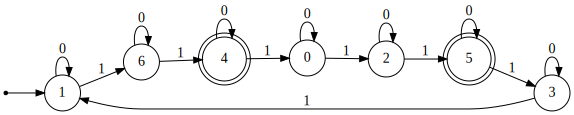

In [135]:
decision_tree_to_dfa(
    alphabet_size=2,
    dt=dt,
    oracle=oracle,
    sampler=us,
    min_samples_per_state=100,
    seed=0,
)

In [126]:
# idx_1, _ = pst.best_correlation_in_bank()
# vs = pst.query_for_mask(pst.corresponding_masks[idx_1])
# print(len(vs) / len(pst.suffix_bank))
# # pst.finish_populating_suffix_family(vs)

In [34]:
mask_1 = pst.compute_decision(vs) < 0.4

In [76]:
vs_2 = pst.find_suffix_family(0.05, mask_1)

Completing suffix family:   5%|5         | 1/19 [00:02<00:46,  2.58s/it]

In [77]:
mask_2 = mask_1.copy()
mask_2[mask_1] = pst.compute_decision(vs_2, mask_1) < 0.4

In [79]:
# mask_2.mean()

In [45]:
# 0.65**8 * 3000

In [52]:
(decision_val < 0.35).mean() ** 8 * 3000

np.float64(122.3060053142522)

In [21]:
# sum(pst.suffix_bank[411])

In [13]:
(decision_val > 0.65)

array([False, False, False, ..., False,  True, False], shape=(3000,))

In [228]:
len(vs)

50

In [145]:
# np.array(masks)